In [66]:
from scipy.io import loadmat
from math import sin, cos, tan, degrees, pi, asin, acos, atan2
import numpy as np
import matplotlib.pyplot as plt

In [67]:
dt = 0.01

In [68]:
prevPhi   = 0
prevTheta = 0
prevPsi   = 0

In [69]:
def gengyro():
  mat = loadmat('./source./11.ARS./ArsGyro.mat')
  wx, wy, wz = mat['wx'], mat['wy'], mat['wz']
  for i in range(len(wx)):
    yield wx[i][0], wy[i][0], wz[i][0]

In [70]:
ps, qs, rs, times = [], [], [], []

Nsamples = 41500
dt = 0.01

getgyro = gengyro()
for i in range(Nsamples):
  p, q, r = next(getgyro)
  ps.append(p)
  qs.append(q)
  rs.append(r)
  times.append(i*dt)

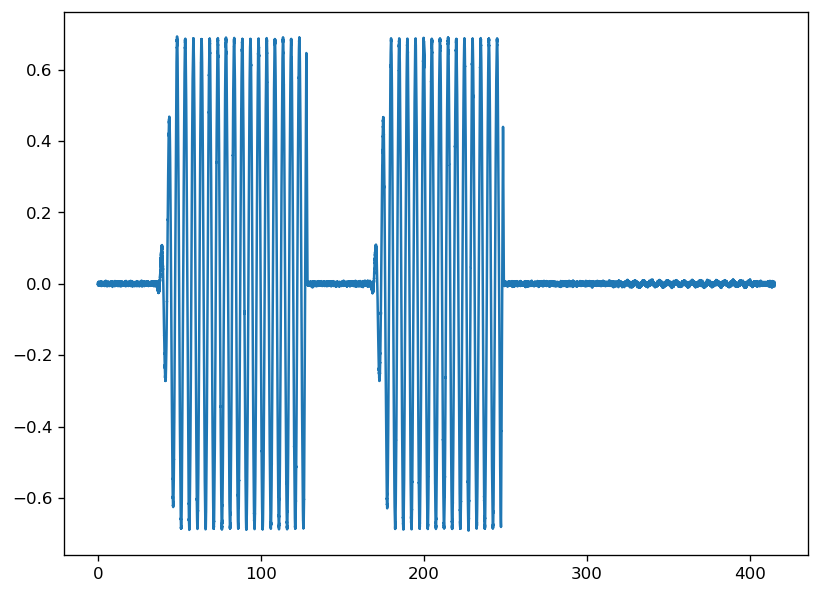

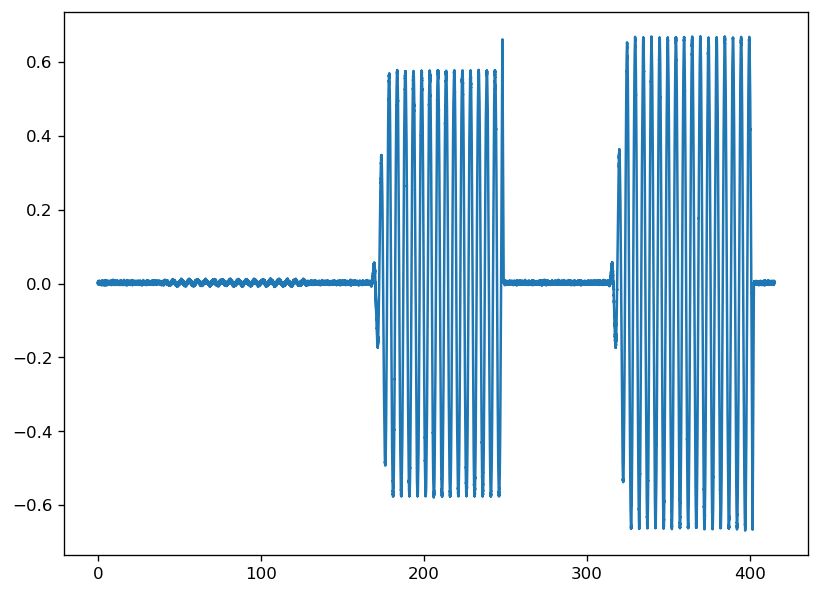

In [71]:
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, ps)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, qs)
plt.show()

In [72]:
def eulergyro(p, q, r, dt):
  global prevPhi, prevTheta, prevPsi

  sinPhi   = sin(prevPhi)
  cosPhi   = cos(prevPhi)
  cosTheta = cos(prevTheta)
  tanTheta = tan(prevTheta)

  phi   = prevPhi   + dt*( p + q*sinPhi*tanTheta + r*cosPhi*tanTheta )
  theta = prevTheta + dt*(     q*cosPhi          - r*sinPhi )
  psi   = prevPsi   + dt*(     q*sinPhi/cosTheta + r*cosPhi/cosTheta )

  prevPhi   = phi
  prevTheta = theta
  prevPsi   = psi

  return phi, theta, psi

In [73]:
prevPhi   = 0
prevTheta = 0
prevPsi   = 0

phis, thetas, psis, times = [], [], [], []

Nsamples = 41500
dt = 0.01

getgyro = gengyro()
for i in range(Nsamples):
  p, q, r = next(getgyro)
  phi, theta, psi = eulergyro(p, q, r, dt)
  
  phis.append(degrees(phi))
  thetas.append(degrees(theta))
  psis.append(degrees(psi))
  times.append(i*dt)


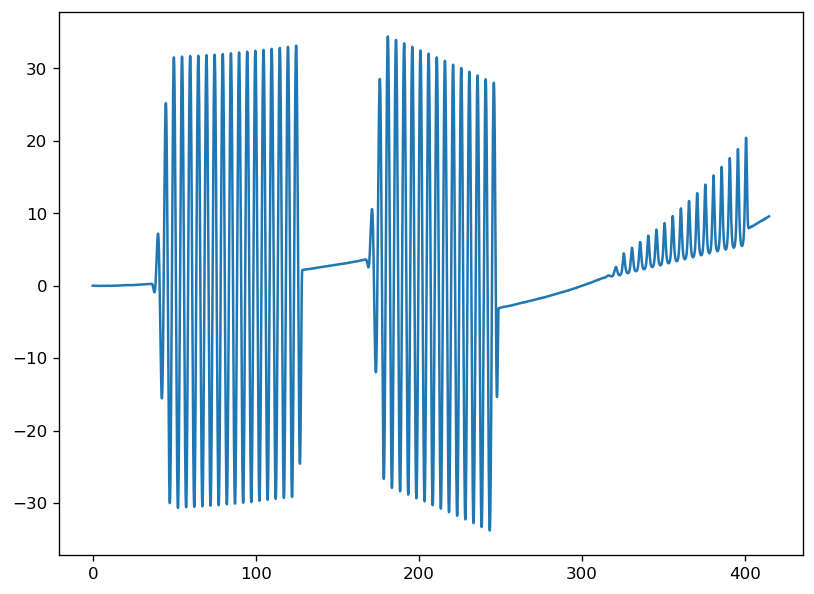

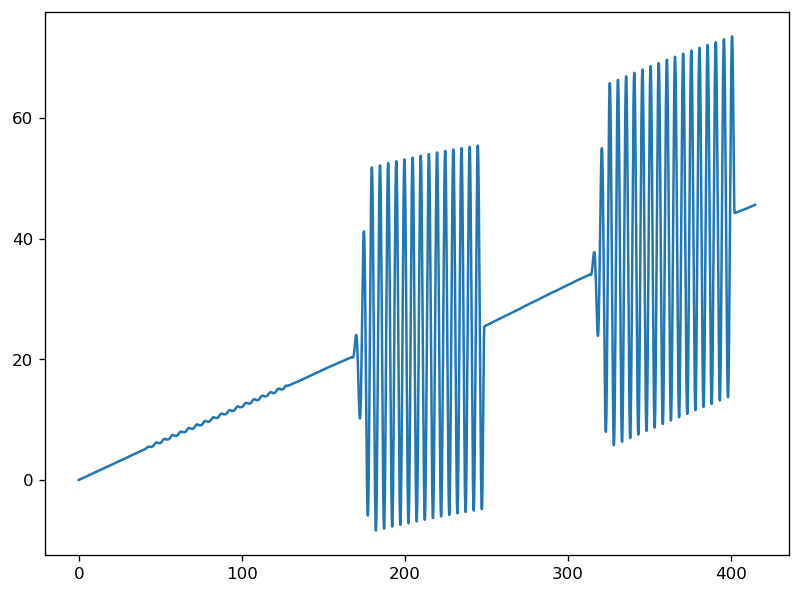

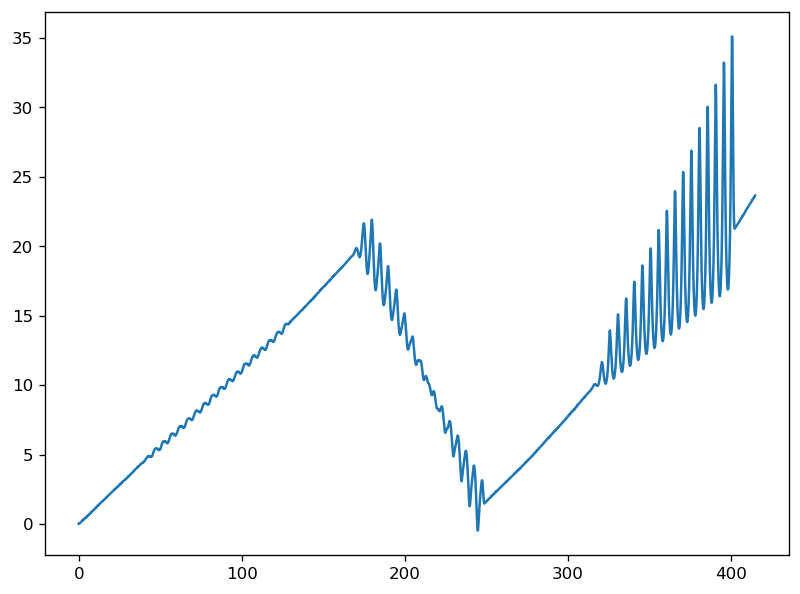

In [74]:
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, phis)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, thetas)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, psis)
plt.show()

In [75]:
def genaccel():
  mat = loadmat('./source./11.ARS./ArsAccel.mat')
  fx, fy, fz = mat['fx'], mat['fy'], mat['fz']
  for i in range(len(fx)):
    yield fx[i][0], fy[i][0], fz[i][0]

In [76]:
fxs, fys, fzs, times = [], [], [], []

Nsamples = 41500
dt = 0.01

getgyro = gengyro()
for i in range(Nsamples):
  fx, fy, fz = next(getgyro)
  fxs.append(fx)
  fys.append(fy)
  fzs.append(fz)
  times.append(i*dt)

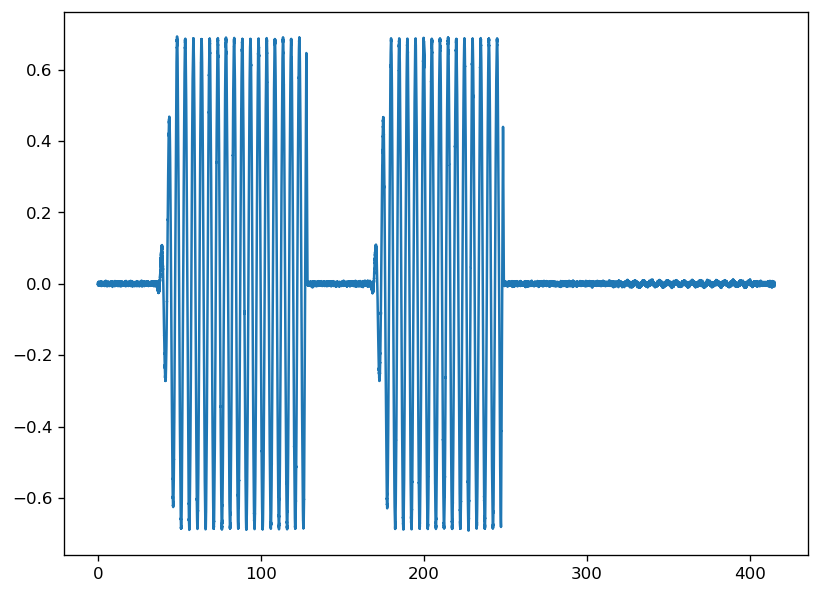

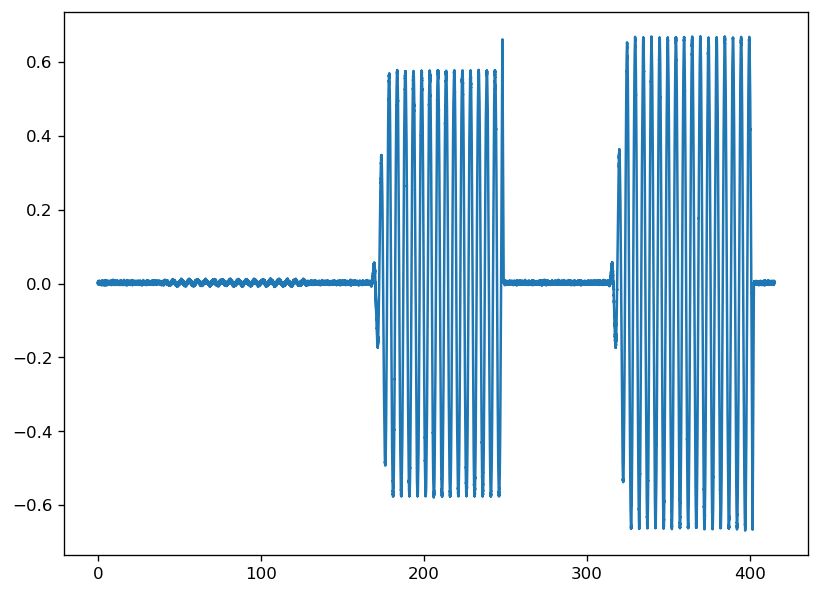

In [77]:
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, fxs)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, fys)
plt.show()

In [78]:
def euleraccel(ax, ay):
  g = 9.8

  theta = asin(  ax / g )
  phi   = asin( -ay / (g*cos(theta)) )

  return phi, theta

In [79]:
phis, thetas, times = [], [], []

Nsamples = 41500
dt = 0.01

getaccel = genaccel()
for i in range(Nsamples):
  fx, fy, _ = next(getaccel)
  phi, theta = euleraccel(fx, fy)
  
  phis.append(degrees(phi))
  thetas.append(degrees(theta))
  times.append(i*dt)


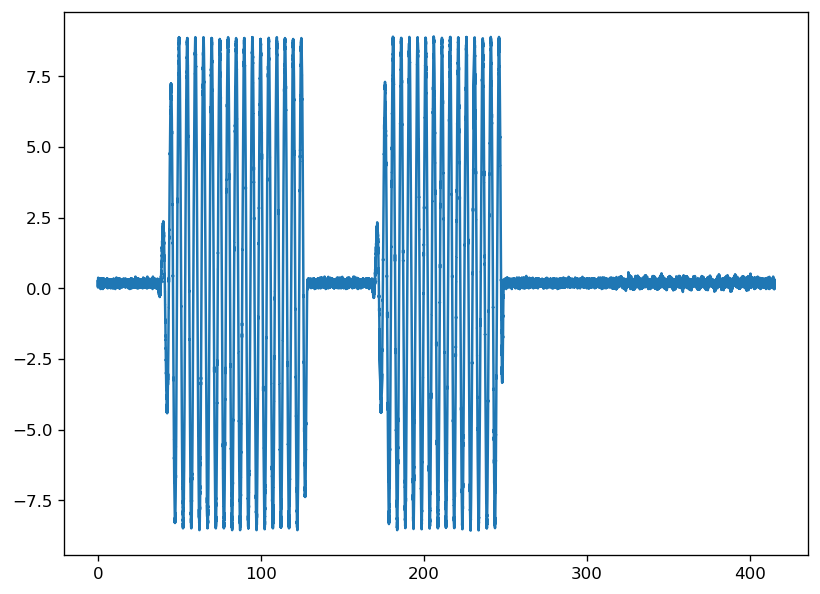

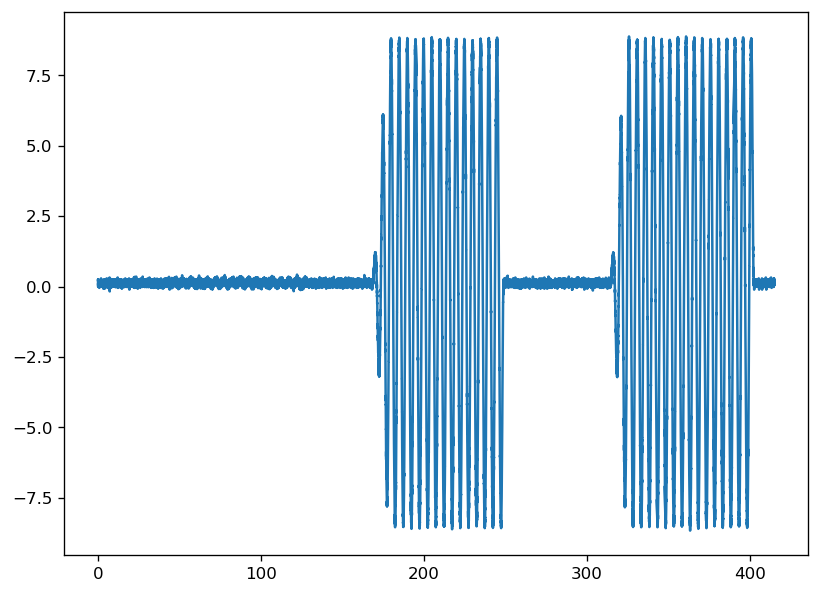

In [80]:
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, phis)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, thetas)
plt.show()

# Do Kalman filter

1. Define state variables; $x$ (in quaternion)
$$
x = 
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4\\
\end{bmatrix}
$$


2. Acquire system dynamics; $A$
$$
\begin{aligned}

\dot{x} &= Ax \\
A &=
\frac{1}{2}
\begin{bmatrix}
0 & -p & -q & -r\\
p & 0 & r & -q\\
q & -r & 0 & p\\
r & q & -p & 0\\
\end{bmatrix}
\end{aligned}
$$


3. Convert system dynamics to state transition matrix; $F$
$$
\begin{aligned}
x_{k+1} &= x_k + \frac{1}{2} \Delta t 
\begin{bmatrix}
0 & -p & -q & -r\\
p & 0 & r & -q\\
q & -r & 0 & p\\
r & q & -p & 0\\
\end{bmatrix} x_k \\
x_{k+1} &= \left(I + \frac{1}{2} \Delta t 
\begin{bmatrix}
0 & -p & -q & -r\\
p & 0 & r & -q\\
q & -r & 0 & p\\
r & q & -p & 0\\
\end{bmatrix} \right) x_k \\
F &= I + \frac{1}{2} \Delta t 
\begin{bmatrix}
0 & -p & -q & -r\\
p & 0 & r & -q\\
q & -r & 0 & p\\
r & q & -p & 0\\
\end{bmatrix}
\end{aligned}
$$


4. Define observation matrix; $H$
$$
H =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
$$
* Measurement(=Gyro) should be converted to quaternion



5. Define noise covariance matrixs; $Q$ and $R$
$$
Q = 
\begin{bmatrix}
0.0001 & 0 & 0 & 0\\
0 & 0.0001 & 0 & 0\\
0 & 0 & 0.0001 & 0\\
0 & 0 & 0 & 0.0001\\
\end{bmatrix}
, R = 
\begin{bmatrix}
10 & 0 & 0 & 0\\
0 & 10 & 0 & 0\\
0 & 0 & 10 & 0\\
0 & 0 & 0 & 10\\
\end{bmatrix}\\
$$

6. Set initial state and covariance; $\hat{x}_{\bar{0}}$, $P_{\bar{0}}$
$$
\hat{x}_{\bar{0}} = 
\begin{bmatrix}
1 \\ 0 \\ 0 \\ 0
\end{bmatrix}
, P_{\bar{0}} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
$$


In [81]:
def initialize():
  global H, Q, R, x, P
  H = np.eye(4)
  Q = 0.0001*np.eye(4)
  R = 10*np.eye(4)
  x = np.array([1, 0, 0, 0]).T
  P = np.eye(4)

In [82]:
def eulerkalman(F, z):
  global x, P
  
  xp = F@x
  Pp = F@P@F.T + Q

  K = Pp@H.T@np.linalg.inv(H@Pp@H.T + R)

  x = xp + K@(z - H@xp)
  P = Pp - K@H@Pp

  # print(x)
  phi   =  atan2( 2*(x[2]*x[3] + x[0]*x[1]), 1 - 2*(x[1]**2 + x[2]**2) )
  theta = -asin(  2*(x[1]*x[3] - x[0]*x[2]) )
  psi   =  atan2( 2*(x[1]*x[2] + x[0]*x[3]), 1 - 2*(x[2]**2 + x[3]**2) )
  
  return phi, theta, psi
  

In [83]:
def euler2quaternion(phi, theta, psi):
  sinPhi   = sin(phi/2);    cosPhi   = cos(phi/2)
  sinTheta = sin(theta/2);  cosTheta = cos(theta/2)
  sinPsi   = sin(psi/2);    cosPsi   = cos(psi/2)

  return np.array([cosPhi*cosTheta*cosPsi + sinPhi*sinTheta*sinPsi,
          sinPhi*cosTheta*cosPsi - cosPhi*sinTheta*sinPsi,
          cosPhi*sinTheta*cosPsi + sinPhi*cosTheta*sinPsi,
          cosPhi*cosTheta*sinPsi - sinPhi*sinTheta*cosPsi,
        ]).T

In [84]:
phis, thetas, psis, times = [], [], [], []

Nsamples = 41500
dt = 0.01
H = np.eye(4)
Q = 0.0001*np.eye(4)
R = 10*np.eye(4)
x = np.array([1, 0, 0, 0]).T
P = np.eye(4)

getgyro = gengyro()
getaccel = genaccel()

for i in range(Nsamples):
  p, q, r = next(getgyro)
  F = np.eye(4) + dt*0.5*np.array([[0, -p, -q, -r], [p, 0, r, -q], [q, -r, 0, p], [r, q, -p, 0]])
  
  ax, ay, az = next(getaccel)
  phi, theta = euleraccel(ax, ay)
  z = euler2quaternion(phi, theta, 0)

  phi, theta, psi = eulerkalman(F, z)
  
  phis.append(degrees(phi))
  thetas.append(degrees(theta))
  psis.append(degrees(psi))
  times.append(i*dt)


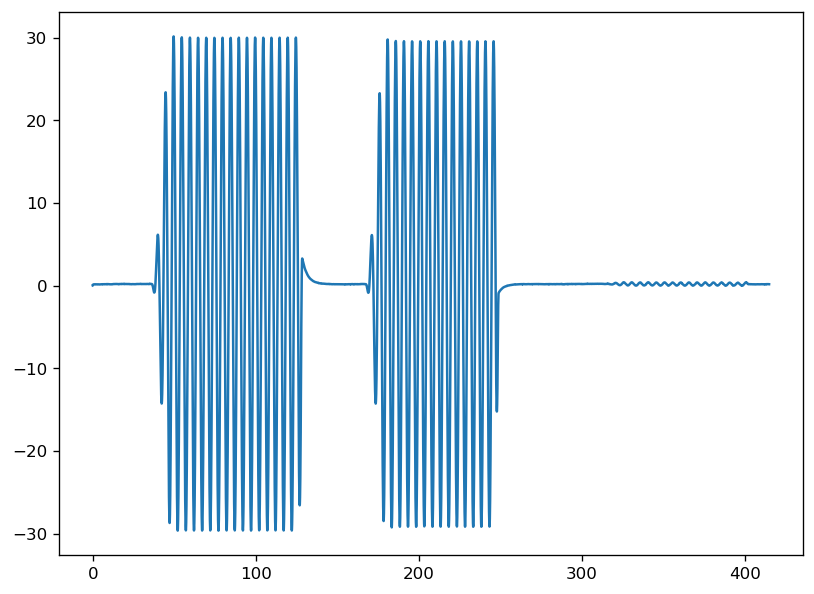

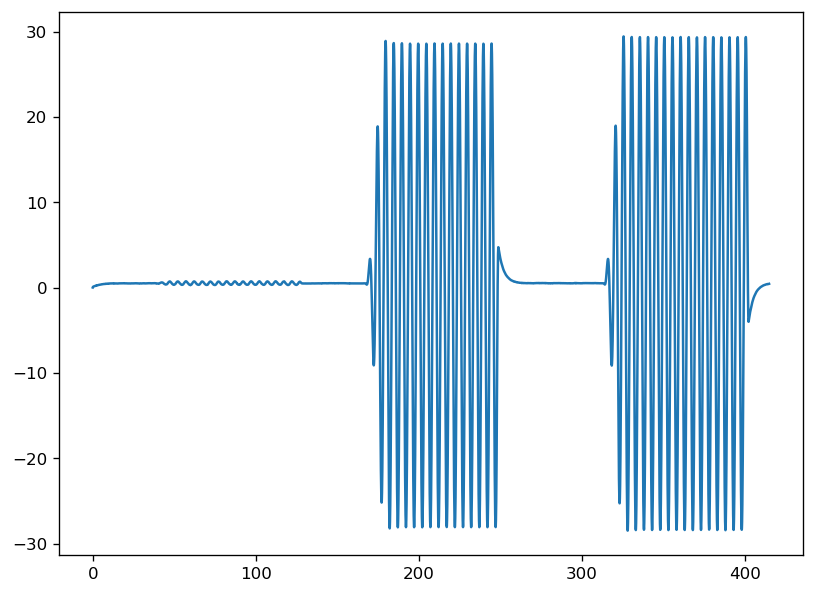

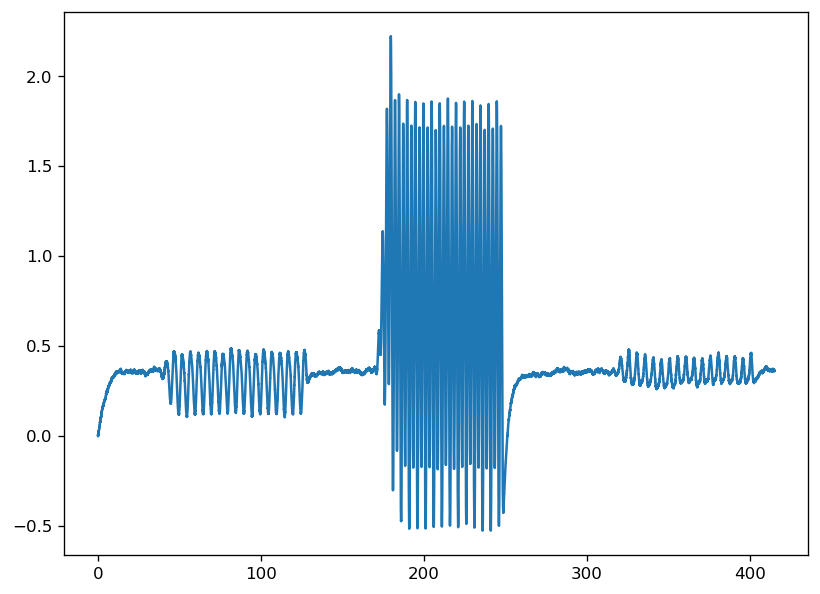

In [85]:
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, phis)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, thetas)
plt.show()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(times, psis)
plt.show()